# CNN on mnist with convolution visualization

This is heavily based on keras' example : https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py

This is for the **keras v1** api

In [1]:
import os
#os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=gpu,floatX=float32'

skipTraining = False # Skip training and load trained weights

# This gives a 'perform' error in compile
#os.environ['THEANO_FLAGS']='mode=FAST_COMPILE,device=gpu1,floatX=float32'
#os.environ['THEANO_FLAGS']='device=gpu0'

#os.environ['KERAS_BACKEND'] = 'tensorflow'
#os.environ['THEANO_FLAGS']='mode=FAST_COMPILE,device=cpu,floatX=float32'

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from __future__ import absolute_import
from __future__ import print_function
import pylab as pl
import matplotlib.cm as cm
import numpy as np
np.random.seed(1337) # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils

%matplotlib inline

'''
    Train a simple convnet on the MNIST dataset.

    Run on GPU: THEANO_FLAGS=mode=FAST_RUN,device=gpu,floatX=float32 python mnist_cnn.py

    Get to 99.25% test accuracy after 12 epochs (there is still a lot of margin for parameter tuning).
    16 seconds per epoch on a GRID K520 GPU.
'''

Using TensorFlow backend.


'\n    Train a simple convnet on the MNIST dataset.\n\n    Run on GPU: THEANO_FLAGS=mode=FAST_RUN,device=gpu,floatX=float32 python mnist_cnn.py\n\n    Get to 99.25% test accuracy after 12 epochs (there is still a lot of margin for parameter tuning).\n    16 seconds per epoch on a GRID K520 GPU.\n'

In [3]:
import theano
print(theano.config.device)

cpu


In [4]:
np.set_printoptions(precision=5, suppress=True)

In [5]:
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print('X_test shape:', X_test.shape)
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)
print(y_train)

X_train shape: (60000, 1, 28, 28)
60000 train samples
X_test shape: (10000, 1, 28, 28)
10000 test samples
[5 0 4 ..., 5 6 8]


label :  [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


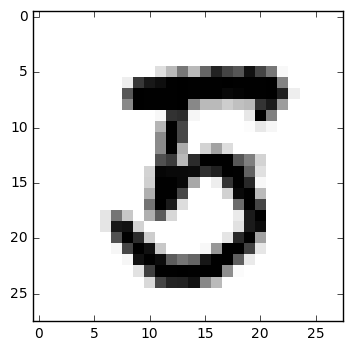

In [6]:
i = 4600
pl.imshow(X_train[i, 0], interpolation='nearest', cmap=cm.binary)
print("label : ", Y_train[i,:])

In [7]:
model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='valid', input_shape=X_train.shape[1:]))
# The Dropout is not in the original keras example, it's just here to demonstrate how to
# correctly handle train/predict phase difference when visualizing convolutions below
model.add(Dropout(0.1))
convout1 = Activation('relu')
model.add(convout1)
model.add(Convolution2D(32, 3, 3))

convout2 = Activation('relu')
model.add(convout2)
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

ValueError: Filter must not be larger than the input: Filter: (3, 3) Input: (1, 28)

In [ ]:
# Uncomment to visualize
#from IPython.display import SVG
#from keras.utils.visualize_util import model_to_dot
#SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
WEIGHTS_FNAME = 'mnist_cnn_weights_v1.hdf'
if skipTraining and os.path.exists(WEIGHTS_FNAME):
    # Just change the True to false to force re-training
    print('Loading existing weights')
    model.load_weights(WEIGHTS_FNAME)
else:
    batch_size = 128
    nb_epoch = 12
    model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
              verbose=1, validation_data=(X_test, Y_test))
    model.save_weights(WEIGHTS_FNAME, overwrite=True)
score = model.evaluate(X_test, Y_test, show_accuracy=True, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

In [ ]:
print("Predicted: ")
print(model.predict(X_test[:5]))
print("Answer: ")
print(Y_test[:5])

In [ ]:
Y_pred = model.predict(X_test)
# Convert one-hot to index
y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

## Convolution visualizations

In [ ]:
from keras import backend as K

In [ ]:
# K.learning_phase() is a flag that indicates if the network is in training or
# predict phase. It allow layer (e.g. Dropout) to only be applied during training
inputs = [K.learning_phase()] + model.inputs

_convout1_f = K.function(inputs, [convout1.output])
def convout1_f(X):
    # The [0] is to disable the training phase flag
    return _convout1_f([0] + [X])

In [ ]:
# utility functions
from mpl_toolkits.axes_grid1 import make_axes_locatable

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    pl.colorbar(im, cax=cax)

In [ ]:
i = 4601

# Visualize the first layer of convolutions on an input image
X = X_test[i:i+1]

pl.figure()
pl.title('input')
nice_imshow(pl.gca(), np.squeeze(X), vmin=0, vmax=1, cmap=cm.binary)

In [ ]:
import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in xrange(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

#pl.imshow(make_mosaic(np.random.random((9, 10, 10)), 3, 3, border=1))

In [ ]:
# Visualize weights
W = model.layers[0].W.get_value(borrow=True)
W = np.squeeze(W)
print("W shape : ", W.shape)

pl.figure(figsize=(15, 15))
pl.title('conv1 weights')
nice_imshow(pl.gca(), make_mosaic(W, 6, 6), cmap=cm.binary)

In [ ]:
# Visualize convolution result (after activation)
C1 = convout1_f(X)
C1 = np.squeeze(C1)
print("C1 shape : ", C1.shape)

pl.figure(figsize=(15, 15))
pl.suptitle('convout1')
nice_imshow(pl.gca(), make_mosaic(C1, 6, 6), cmap=cm.binary)

# Train on cspad images

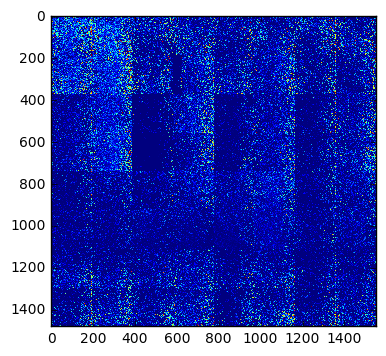

(2760, 1480, 1552)
float64
<class 'h5py._hl.dataset.Dataset'>


In [26]:
import psana
import h5py
f = h5py.File('/reg/d/psdm/cxi/cxitut13/res/yoon82/cxis0813/cxis0813_0032.cxi','r')
imgs = f['/entry_1/data_1/data']
# f.close()
#print(run)

# input image dimensions
# img.shape
plt.imshow(imgs[1500,:,:],interpolation='none',vmax=50,vmin=0)
plt.show()

print(imgs.shape)
print(imgs.dtype)
print(type(imgs))

In [28]:
# override the real # of events
numEvents = imgs.shape[0]

numTrain = 5
numTest = 5

randList = np.random.permutation(numEvents)
trainList = randList[:numTrain]
testList = randList[numTrain:(numTest+numTest)]

print(randList)
print(trainList)
print(testList)

X_train = np.empty([numTrain, imgs.shape[1], imgs.shape[2], 1])
X_test = np.empty([numTest, imgs.shape[1], imgs.shape[2], 1])


for t in range(0, numTrain):
    n = trainList[t]
    img = imgs[n,:,:]
    img_reshape = np.reshape(img, [imgs.shape[1], imgs.shape[2], 1])
    X_train[t,:,:,:] = img_reshape

print(X_train.shape)    
    
for t in range(0, numTest):
    n = testList[t]
    img = imgs[t,:,:]
    img_reshape = np.reshape(img, [imgs.shape[1], imgs.shape[2], 1])
    X_test[t,:,:,:] = img_reshape  

print(X_test.shape)    


[1389 1305 1590 ..., 2416 2652 2043]
[1389 1305 1590 2470 2490]
[1369 2336 1658  259  327]
(5, 1480, 1552, 1)
(5, 1480, 1552, 1)


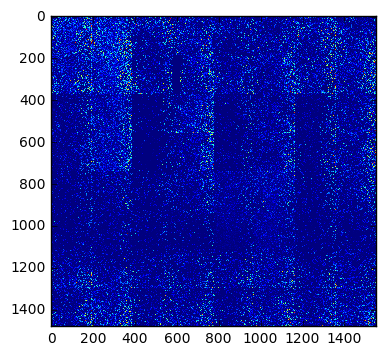

In [29]:
import matplotlib.pyplot as plt
plt.imshow(img,interpolation='none',vmax=50,vmin=0)
plt.show()

[ 23  23  82 113  74]
[0 0 1 1 1]
[ 28 102  16 124 148]
[0 1 0 1 1]


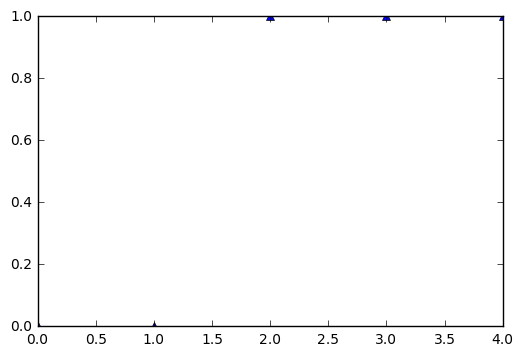

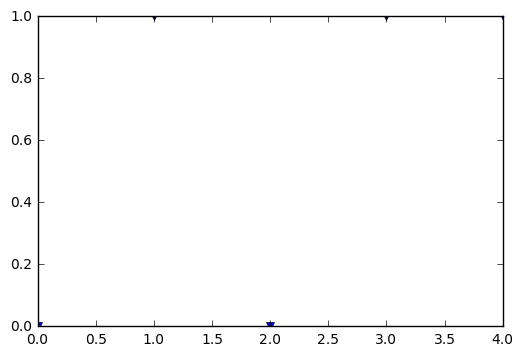

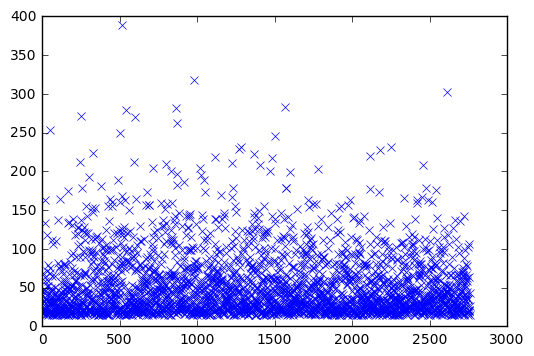

In [30]:
# import h5py
# f = h5py.File('/reg/d/psdm/cxi/cxitut13/res/yoon82/cxis0813/cxis0813_0032.cxi','r')
indexed = f['/entry_1/result_1/nPeaks'].value
# f.close()

y_train = indexed[trainList]
print(y_train)
y_train = y_train > 50
y_train = 1 * y_train 
print(y_train)


y_test = indexed[testList]
print(y_test)
y_test = y_test > 50
y_test = 1 * y_test 
print(y_test)

plt.plot(y_train,'^')
plt.show()

plt.plot(y_test,'v')
plt.show()

plt.plot(indexed,'x')
plt.show()

In [31]:
nb_classes = 2

Y_train = np_utils.to_categorical(y_train, nb_classes)

print(Y_train)

Y_test = np_utils.to_categorical(y_test, nb_classes)

print(Y_test)

[[ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]]
[[ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]]


In [32]:
model = Sequential()

print(X_train.shape[1:])

model.add(Convolution2D(32, 3, 3, border_mode='valid', input_shape=X_train.shape[1:]))
# The Dropout is not in the original keras example, it's just here to demonstrate how to
# correctly handle train/predict phase difference when visualizing convolutions below
model.add(Dropout(0.1))
convout1 = Activation('relu')
model.add(convout1)
model.add(Convolution2D(32, 3, 3))

convout2 = Activation('relu')
model.add(convout2)
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

(1480, 1552, 1)


In [ ]:


batch_size = 5
nb_epoch = 3
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
    verbose=1, validation_data=(X_test, Y_test))

In [36]:
WEIGHTS_FNAME = '/reg/d/psdm/cxi/cxitut13/scratch/liponan/ml/cspad_cnn_weights_v1.hdf'
model.save_weights(WEIGHTS_FNAME, overwrite=True)
score = model.evaluate(X_test, Y_test, show_accuracy=True, verbose=0)

The history saving thread hit an unexpected error (OperationalError('unable to open database file',)).History will not be written to the database.


/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.0.5/lib/python2.7/site-packages/keras/models.py:644: UserWarning: The "show_accuracy" argument is deprecated, instead you should pass the "accuracy" metric to the model at compile time:
`model.compile(optimizer, loss, metrics=["accuracy"])`
  warnings.warn('The "show_accuracy" argument is deprecated, '


In [37]:
print(score)
print('Test score:', score[0])
print('Test accuracy:', score[1])

[9.6708574295043945, 0.40000000596046448]
Test score: 9.6708574295
Test accuracy: 0.40000000596


In [38]:
print(123)

123
